In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


In [11]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [12]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [13]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [14]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [15]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [16]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [17]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [19]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>CNN 1</h1>

In [20]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 128)               1032320   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1034886 (3.95 MB)
Trainable params: 1034886 (3.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 4s 48ms/step - loss: 0.5360 - accuracy: 0.7787 - val_loss: 0.2687 - val_accuracy: 0.9093
Epoch 2/10
58/58 [==============================] - 2s 42ms/step - loss: 0.2179 - accuracy: 0.9173 - val_loss: 0.1538 - val_accuracy: 0.9461
Epoch 3/10
58/58 [==============================] - 4s 68ms/step - loss: 0.1505 - accuracy: 0.9426 - val_loss: 0.1280 - val_accuracy: 0.9524
Epoch 4/10
58/58 [==============================] - 5s 93ms/step - loss: 0.1214 - accuracy: 0.9532 - val_loss: 0.1120 - val_accuracy: 0.9542
Epoch 5/10
58/58 [==============================] - 3s 59ms/step - loss: 0.1110 - accuracy: 0.9536 - val_loss: 0.1104 - val_accuracy: 0.9578
Epoch 6/10
58/58 [==============================] - 3s 54ms/step - loss: 0.1113 - accuracy: 0.9533 - val_loss: 0.1027 - val_accuracy: 0.9574
Epoch 7/10
58/58 [==============================] - 4s 72ms/step - loss: 0.1029 - accuracy: 0.9550 - val_loss: 0.0959 - val_accuracy: 0.9651
Epoch 8/10
58

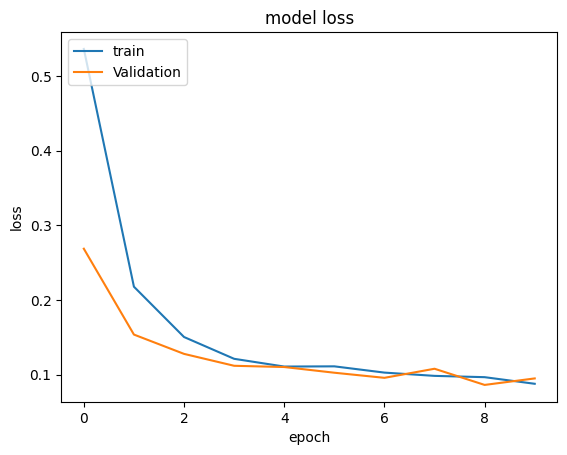

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

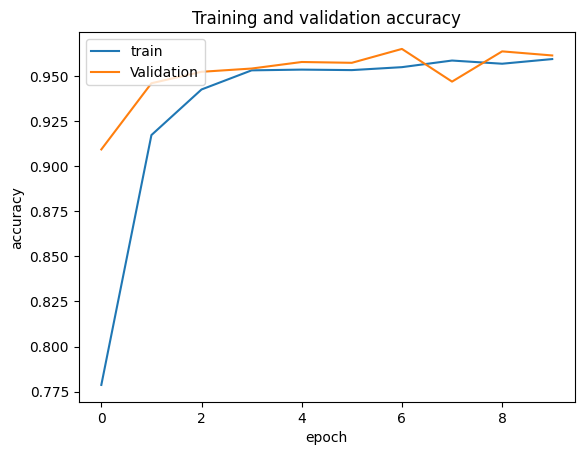

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 15ms/step
[[452   5  38   1   0   0]
 [  6 439  25   0   0   1]
 [  3   5 411   1   0   0]
 [  0  24   0 424  43   0]
 [  0   7   0 101 424   0]
 [  0  27   0   0   0 510]]
0.9026128266033254
0.9028815630102218
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       496
           1       0.87      0.93      0.90       471
           2       0.87      0.98      0.92       420
           3       0.80      0.86      0.83       491
           4       0.91      0.80      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

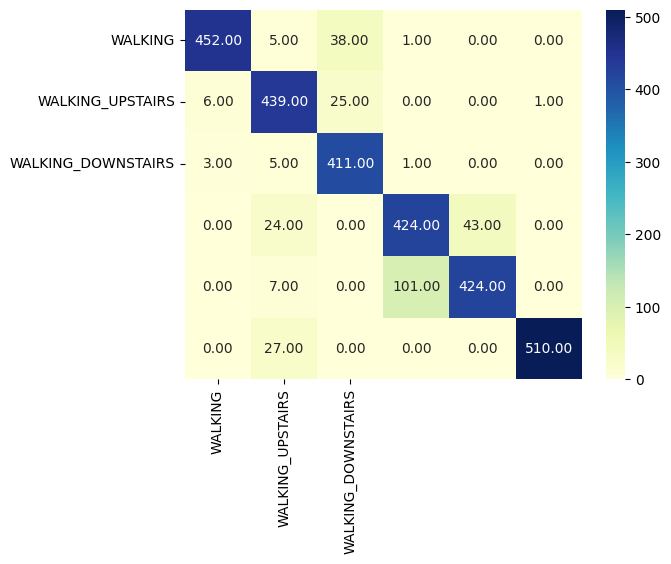

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2</h2>

In [25]:
# Model 2
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1015936   
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1030854 (3.93 MB)
Trainable params: 1030854 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 9s 137ms/step - loss: 0.5637 - accuracy: 0.7825 - val_loss: 0.2578 - val_accuracy: 0.9161
Epoch 2/10
58/58 [==============================] - 10s 172ms/step - loss: 0.1878 - accuracy: 0.9294 - val_loss: 0.1436 - val_accuracy: 0.9461
Epoch 3/10
58/58 [==============================] - 8s 139ms/step - loss: 0.1308 - accuracy: 0.9472 - val_loss: 0.1373 - val_accuracy: 0.9397
Epoch 4/10
58/58 [==============================] - 5s 88ms/step - loss: 0.1073 - accuracy: 0.9535 - val_loss: 0.1085 - val_accuracy: 0.9497
Epoch 5/10
58/58 [==============================] - 8s 146ms/step - loss: 0.1019 - accuracy: 0.9557 - val_loss: 0.1035 - val_accuracy: 0.9519
Epoch 6/10
58/58 [==============================] - 5s 92ms/step - loss: 0.1034 - accuracy: 0.9554 - val_loss: 0.0903 - val_accuracy: 0.9655
Epoch 7/10
58/58 [==============================] - 4s 77ms/step - loss: 0.0934 - accuracy: 0.9607 - val_loss: 0.0878 - val_accuracy: 0.9655
Epoch 8/

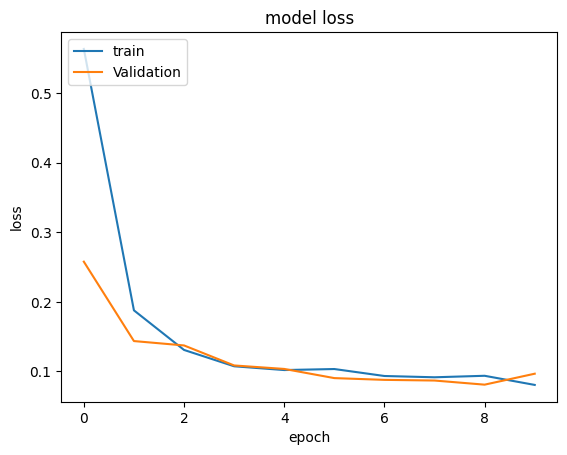

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

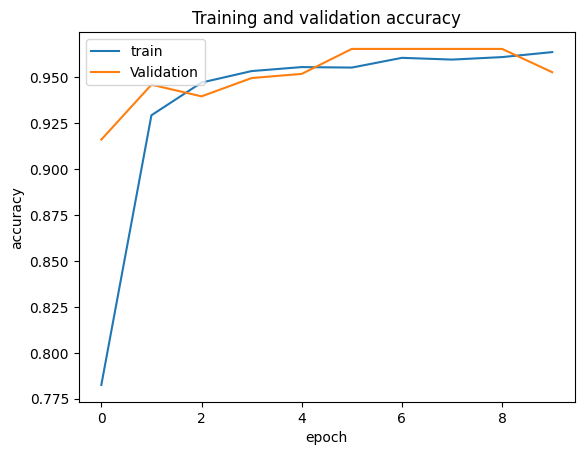

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

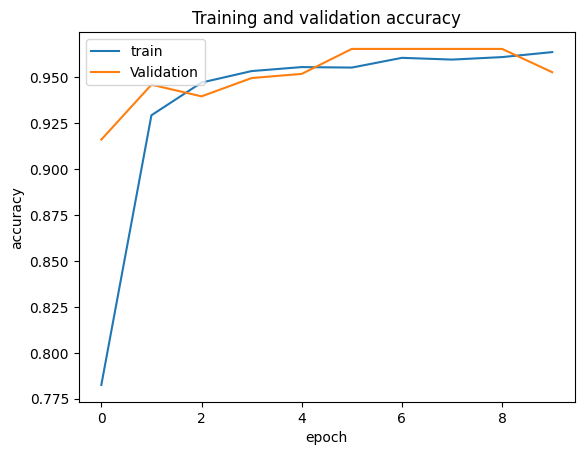

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 19ms/step
[[452  26  18   0   0   0]
 [  0 447  24   0   0   0]
 [  3   5 412   0   0   0]
 [  0  25   0 317 149   0]
 [  0  67   0  25 440   0]
 [  0  27   0   0   0 510]]
0.8747879199185612
0.8741787251276952
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       496
           1       0.75      0.95      0.84       471
           2       0.91      0.98      0.94       420
           3       0.93      0.65      0.76       491
           4       0.75      0.83      0.79       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.87      0.87      2947



<Axes: >

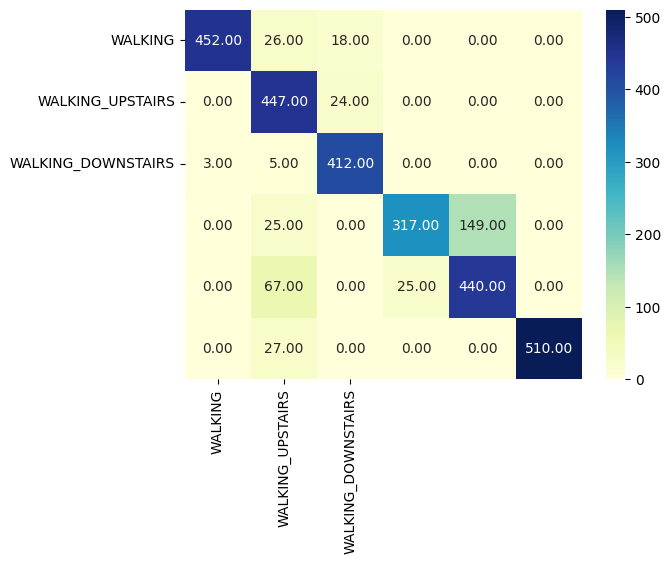

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 3</h1>

In [31]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 64)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 3904)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               499840    
                                                      

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 17s 219ms/step - loss: 0.6262 - accuracy: 0.7410 - val_loss: 0.3125 - val_accuracy: 0.9021
Epoch 2/10
58/58 [==============================] - 12s 210ms/step - loss: 0.2098 - accuracy: 0.9177 - val_loss: 0.1739 - val_accuracy: 0.9270
Epoch 3/10
58/58 [==============================] - 9s 152ms/step - loss: 0.1364 - accuracy: 0.9437 - val_loss: 0.1161 - val_accuracy: 0.9556
Epoch 4/10
58/58 [==============================] - 10s 166ms/step - loss: 0.1260 - accuracy: 0.9480 - val_loss: 0.1158 - val_accuracy: 0.9574
Epoch 5/10
58/58 [==============================] - 12s 204ms/step - loss: 0.1106 - accuracy: 0.9535 - val_loss: 0.1013 - val_accuracy: 0.9587
Epoch 6/10
58/58 [==============================] - 10s 178ms/step - loss: 0.1041 - accuracy: 0.9528 - val_loss: 0.1034 - val_accuracy: 0.9592
Epoch 7/10
58/58 [==============================] - 7s 123ms/step - loss: 0.1087 - accuracy: 0.9521 - val_loss: 0.0967 - val_accuracy: 0.9560
E

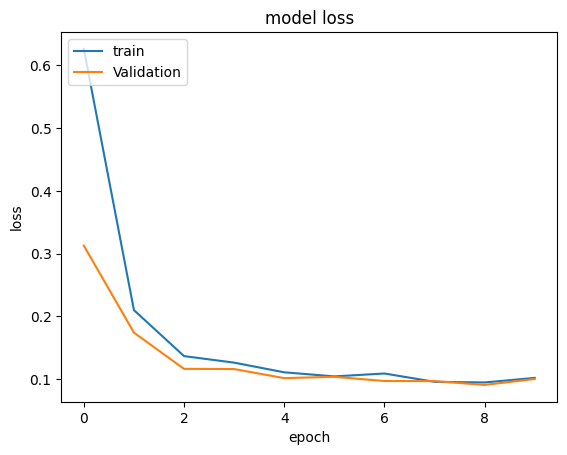

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

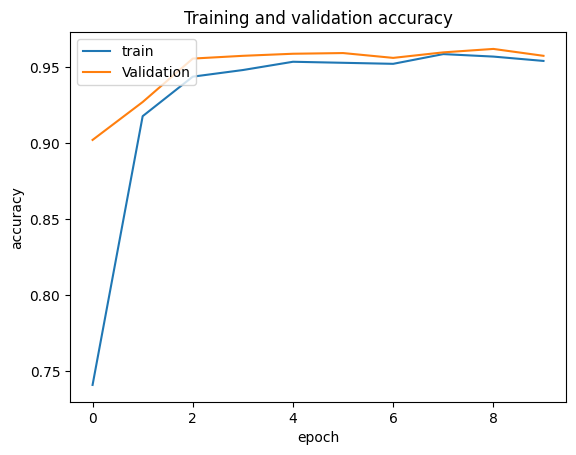

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 22ms/step
[[406  53  36   1   0   0]
 [  0 447  24   0   0   0]
 [  0  10 410   0   0   0]
 [  0  27   0 418  46   0]
 [  0   9   0  98 425   0]
 [  0  27   0   0   0 510]]
0.8876823888700374
0.8883683170099542
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       496
           1       0.78      0.95      0.86       471
           2       0.87      0.98      0.92       420
           3       0.81      0.85      0.83       491
           4       0.90      0.80      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

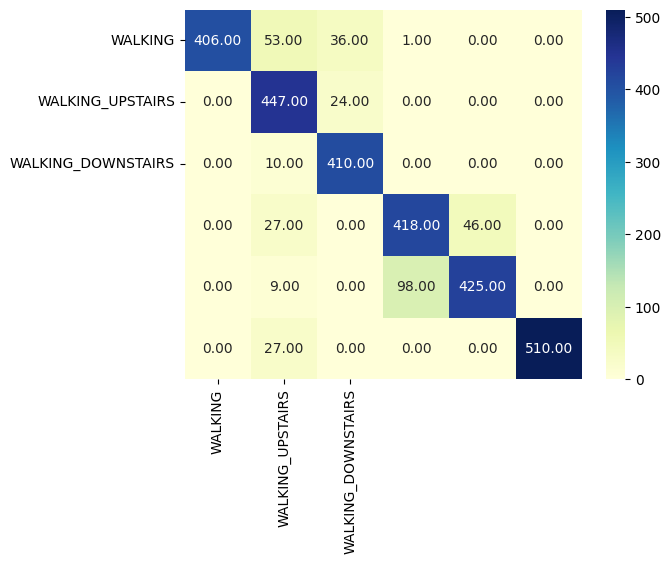

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 4</h1>

In [36]:
# Model 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_7 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_8 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 conv1d_9 (Conv1D)           (None, 120, 64)           12352     
                                                                 
 flatten_3 (Flatten)         (None, 7680)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               983168    
                                                                 
 dense_7 (Dense)             (None, 6)                

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 14s 192ms/step - loss: 0.5331 - accuracy: 0.7839 - val_loss: 0.2380 - val_accuracy: 0.9130
Epoch 2/10
58/58 [==============================] - 9s 163ms/step - loss: 0.1675 - accuracy: 0.9370 - val_loss: 0.1438 - val_accuracy: 0.9393
Epoch 3/10
58/58 [==============================] - 8s 132ms/step - loss: 0.1323 - accuracy: 0.9472 - val_loss: 0.1247 - val_accuracy: 0.9470
Epoch 4/10
58/58 [==============================] - 9s 162ms/step - loss: 0.1137 - accuracy: 0.9535 - val_loss: 0.1070 - val_accuracy: 0.9538
Epoch 5/10
58/58 [==============================] - 7s 129ms/step - loss: 0.1077 - accuracy: 0.9523 - val_loss: 0.1043 - val_accuracy: 0.9587
Epoch 6/10
58/58 [==============================] - 9s 162ms/step - loss: 0.0964 - accuracy: 0.9561 - val_loss: 0.0929 - val_accuracy: 0.9633
Epoch 7/10
58/58 [==============================] - 9s 156ms/step - loss: 0.0981 - accuracy: 0.9557 - val_loss: 0.1076 - val_accuracy: 0.9497
Epoch

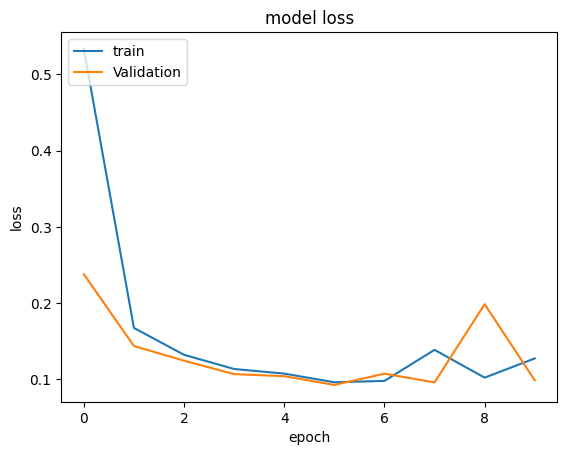

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

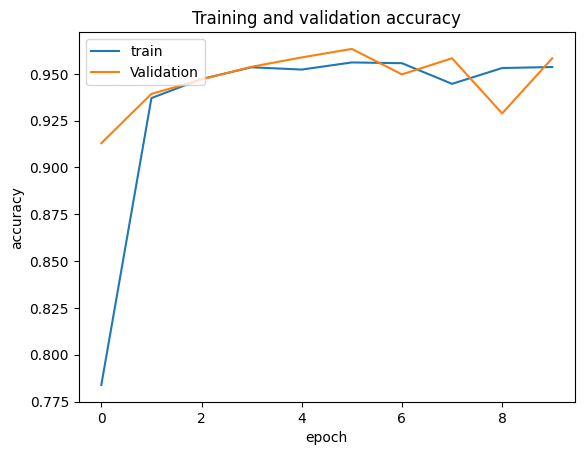

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 18ms/step
[[459  19  18   0   0   0]
 [  6 441  18   0   0   6]
 [  8   6 406   0   0   0]
 [  0  25   0 364 102   0]
 [  2   5   0  47 478   0]
 [  0   0   0   0   0 537]]
0.9110960298608755
0.9100207249701617
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.89      0.94      0.91       471
           2       0.92      0.97      0.94       420
           3       0.89      0.74      0.81       491
           4       0.82      0.90      0.86       532
           5       0.99      1.00      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

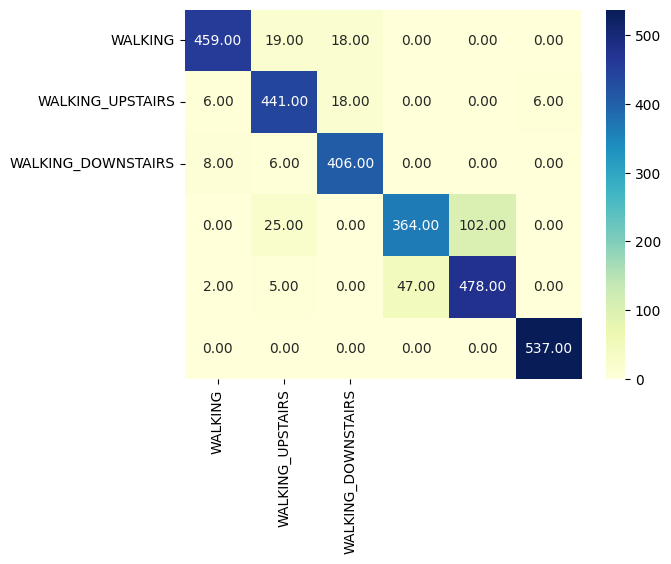

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 5</h1>

In [ ]:
# Model 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [41]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 8s 134ms/step - loss: 0.0914 - accuracy: 0.9589 - val_loss: 0.0817 - val_accuracy: 0.9646
Epoch 2/10
58/58 [==============================] - 10s 170ms/step - loss: 0.0849 - accuracy: 0.9601 - val_loss: 0.0823 - val_accuracy: 0.9624
Epoch 3/10
58/58 [==============================] - 8s 143ms/step - loss: 0.0775 - accuracy: 0.9612 - val_loss: 0.0668 - val_accuracy: 0.9728
Epoch 4/10
58/58 [==============================] - 9s 149ms/step - loss: 0.0713 - accuracy: 0.9649 - val_loss: 0.0615 - val_accuracy: 0.9714
Epoch 5/10
58/58 [==============================] - 10s 168ms/step - loss: 0.0675 - accuracy: 0.9675 - val_loss: 0.0638 - val_accuracy: 0.9696
Epoch 6/10
58/58 [==============================] - 7s 129ms/step - loss: 0.0716 - accuracy: 0.9674 - val_loss: 0.1014 - val_accuracy: 0.9565
Epoch 7/10
58/58 [==============================] - 9s 162ms/step - loss: 0.0752 - accuracy: 0.9656 - val_loss: 0.0591 - val_accuracy: 0.9737
Epoc

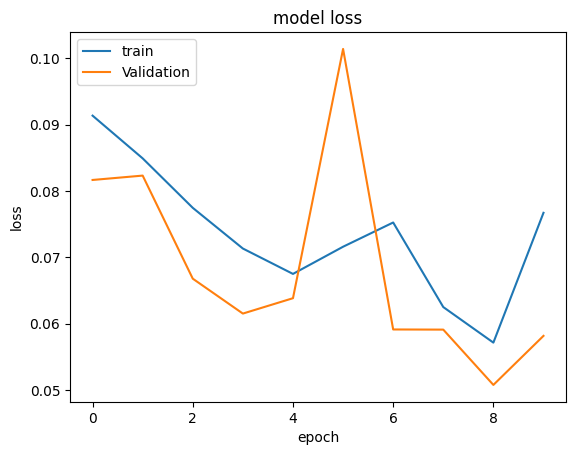

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

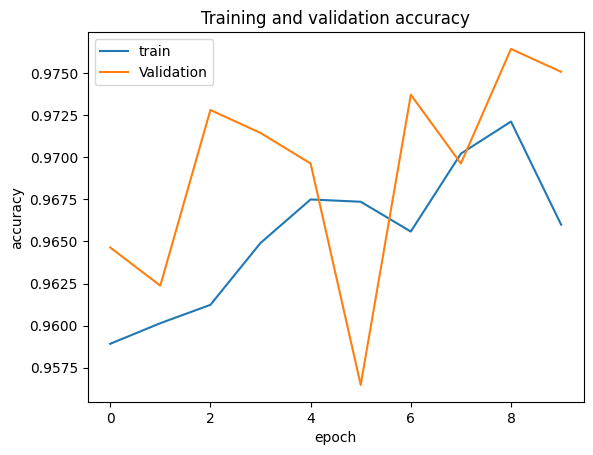

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 11ms/step
[[445   6  45   0   0   0]
 [  7 438  26   0   0   0]
 [  4   4 412   0   0   0]
 [  0  24   0 399  67   1]
 [  0   1   0  78 453   0]
 [  0  27   0   0   0 510]]
0.9015948422124194
0.9017518041448213
              precision    recall  f1-score   support

           0       0.98      0.90      0.93       496
           1       0.88      0.93      0.90       471
           2       0.85      0.98      0.91       420
           3       0.84      0.81      0.82       491
           4       0.87      0.85      0.86       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

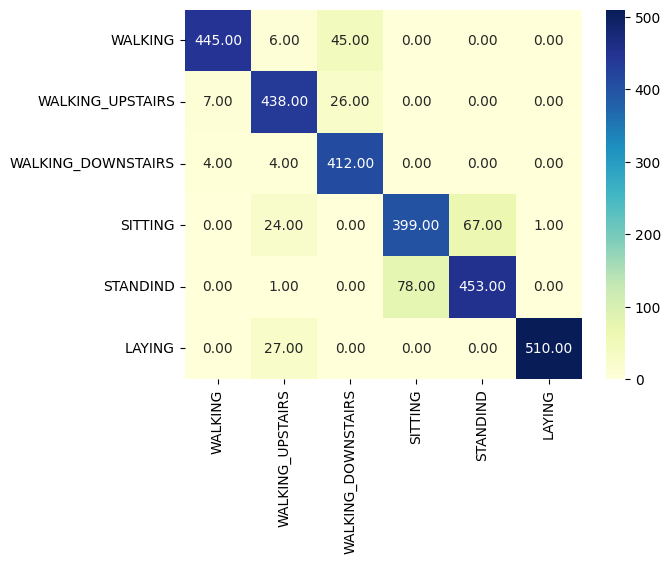

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')